In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot') # Makes plots visually appealing
%matplotlib inline

In [2]:
data = pd.read_csv('/content/ai4i2020.csv')
data.head(5)

,,Product ID,Type,Air temperature_K,Process temperature_K,Rotational speed_RPM,Torque_Nm,Tool wear_Min,Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


In [3]:
print(f'{"Dataset Shape:" , data.shape}')
print(f'{data.isnull().sum()}')

('Dataset Shape:', (10000, 14))
                         0
Product ID               0
Type                     0
Air temperature_K        0
Process temperature_K    0
Rotational speed_RPM     0
Torque_Nm                0
Tool wear_Min            0
Machine failure          0
TWF                      0
HDF                      0
PWF                      0
OSF                      0
RNF                      0
dtype: int64


Step 1: Data Acquisition & Understanding

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
Air temperature_K,10000.0,300.00493,2.000259,295.3,298.30,300.1,301.50,304.5
Process temperature_K,10000.0,310.00556,1.483734,305.7,308.80,310.1,311.10,313.8
Rotational speed_RPM,10000.0,1538.77610,179.284096,1168.0,1423.00,1503.0,1612.00,2886.0
Torque_Nm,10000.0,39.98691,9.968934,3.8,33.20,40.1,46.80,76.6
Tool wear_Min,10000.0,107.95100,63.654147,0.0,53.00,108.0,162.00,253.0
Machine failure,10000.0,0.03390,0.180981,0.0,0.00,0.0,0.00,1.0
TWF,10000.0,0.00460,0.067671,0.0,0.00,0.0,0.00,1.0
HDF,10000.0,0.01150,0.106625,0.0,0.00,0.0,0.00,1.0
PWF,10000.0,0.00950,0.097009,0.0,0.00,0.0,0.00,1.0


In [5]:
#Distribution of failures

failure_count = data['Machine failure'].value_counts()
print("Class Distribution : ", failure_count)

Class Distribution :  Machine failure
0    9661
1     339
Name: count, dtype: int64


In [6]:
failure_rate = data['Machine failure'].mean()*100
print(f'Failure Rate: {failure_rate} %')

Failure Rate: 3.39 %


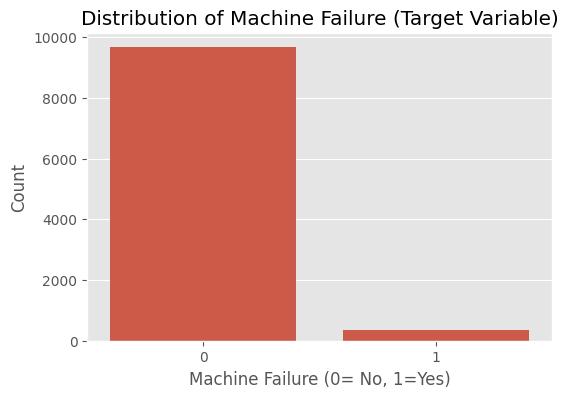

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x='Machine failure',data=data)
plt.title('Distribution of Machine Failure (Target Variable)')
plt.xlabel('Machine Failure (0= No, 1=Yes)')
plt.ylabel('Count')
plt.show()


Step 2: Data Preprocessing & Feature Engineering

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,LabelEncoder
from imblearn.over_sampling import SMOTE

In [9]:
data.columns

Index([' ', 'Product ID', 'Type', 'Air temperature_K', 'Process temperature_K',
       'Rotational speed_RPM', 'Torque_Nm', 'Tool wear_Min', 'Machine failure',
       'TWF', 'HDF', 'PWF', 'OSF', 'RNF'],
      dtype='object')

In [10]:
# Dropping irrelevent columns

X = data.drop(['TWF', 'HDF', 'PWF', 'OSF','RNF', 'Product ID','Machine failure'],axis=1)
y = data['Machine failure']

In [11]:
X.head(5)

,,Type,Air temperature_K,Process temperature_K,Rotational speed_RPM,Torque_Nm,Tool wear_Min
0,1,M,298.1,308.6,1551,42.8,0
1,2,L,298.2,308.7,1408,46.3,3
2,3,L,298.1,308.5,1498,49.4,5
3,4,L,298.2,308.6,1433,39.5,7
4,5,L,298.2,308.7,1408,40.0,9


In [12]:
# Encode Categorical Variable 'Type'

labelencoder= LabelEncoder()
X['Type'] = labelencoder.fit_transform(X['Type'])

In [13]:
for i, class_name in enumerate(labelencoder.classes_) :
  print( f" {class_name} -> {i}")

 H -> 0
 L -> 1
 M -> 2


In [14]:
X.head(5)

,,Type,Air temperature_K,Process temperature_K,Rotational speed_RPM,Torque_Nm,Tool wear_Min
0,1,2,298.1,308.6,1551,42.8,0
1,2,1,298.2,308.7,1408,46.3,3
2,3,1,298.1,308.5,1498,49.4,5
3,4,1,298.2,308.6,1433,39.5,7
4,5,1,298.2,308.7,1408,40.0,9


In [15]:
# Feature 1: Temperature difference (for HDF)

X['Temp_Diff'] =  X['Process temperature_K'] - X['Air temperature_K']

In [16]:
# Feature 2 : Power Calculation (PWF)
X['Power'] = X['Torque_Nm'] * X['Rotational speed_RPM'] *(2*np.pi/60)

In [17]:
# Feature 3 : overstrain failure (OSF)

X['Strain'] = X['Tool wear_Min'] * X['Torque_Nm']

def get_strain_thershold(type_code):
  if type_code == 0:  return 13000
  elif type_code == 1:  return 11000
  else: return 12000

X['Strain_thershold'] = X['Type'].apply(get_strain_thershold)
X['Strain Ratio'] = X['Strain'] / X['Strain_thershold']

In [18]:
X.head(5)

,,Type,Air temperature_K,Process temperature_K,Rotational speed_RPM,Torque_Nm,Tool wear_Min,Temp_Diff,Power,Strain,Strain_thershold,Strain Ratio
0,1,2,298.1,308.6,1551,42.8,0,10.5,6951.590560,0.0,12000,0.000000
1,2,1,298.2,308.7,1408,46.3,3,10.5,6826.722724,138.9,11000,0.012627
2,3,1,298.1,308.5,1498,49.4,5,10.4,7749.387543,247.0,11000,0.022455
3,4,1,298.2,308.6,1433,39.5,7,10.4,5927.504659,276.5,11000,0.025136
4,5,1,298.2,308.7,1408,40.0,9,10.5,5897.816608,360.0,11000,0.032727


In [20]:
# Feature 4: Tool Wear Failure Proximity (for TWF)

twf_min = 200
twf_max = 240

X['Tool Wear Failure Probability'] =  np.select (
   [ X['Tool wear_Min'] > twf_max ,
     X['Tool wear_Min'] <= twf_max,
     X['Tool wear_Min'] < twf_min
   ],

   [0, (X['Tool wear_Min']- twf_min/twf_max - twf_min) , 1 ])

In [22]:
X['TWF_in_critical_zone'] = (X['Tool wear_Min'] >= twf_min).astype(int)

In [23]:
X.head(5)

,,Type,Air temperature_K,Process temperature_K,Rotational speed_RPM,Torque_Nm,Tool wear_Min,Temp_Diff,Power,Strain,Strain_thershold,Strain Ratio,Tool Wear Failure Probability,TWF_in_critical_zone
0,1,2,298.1,308.6,1551,42.8,0,10.5,6951.590560,0.0,12000,0.000000,-200.833333,0
1,2,1,298.2,308.7,1408,46.3,3,10.5,6826.722724,138.9,11000,0.012627,-197.833333,0
2,3,1,298.1,308.5,1498,49.4,5,10.4,7749.387543,247.0,11000,0.022455,-195.833333,0
3,4,1,298.2,308.6,1433,39.5,7,10.4,5927.504659,276.5,11000,0.025136,-193.833333,0
4,5,1,298.2,308.7,1408,40.0,9,10.5,5897.816608,360.0,11000,0.032727,-191.833333,0


In [24]:
#Train-Test Split

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print(f'{"Train Dataset Shape:", X_train.shape}')
print(f'{"Train Dataset Shape:", y_train.shape}')

('Train Dataset Shape:', (8000, 14))
('Train Dataset Shape:', (8000,))


In [25]:
print("\n2.6 - Applying SMOTE to training data...")

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)


2.6 - Applying SMOTE to training data...


In [26]:
print(f'{"y_train_resampled :" , y_train_resampled.shape}')
print(f"New class distribution:\n{pd.Series(y_train_resampled).value_counts()}")

('y_train_resampled :', (15444,))
New class distribution:
Machine failure
0    7722
1    7722
Name: count, dtype: int64


In [27]:
# 2.7 Feature Scaling (Fit on Resampled Train, Transform Both Sets)
print("\n2.7 - Scaling features...")
scaler = StandardScaler()
X_train_res_scaled = scaler.fit_transform(X_train_resampled) # Fit on resampled train
X_test_scaled = scaler.transform(X_test) # Transform test set

# Convert back to DataFrames
X_train_final = pd.DataFrame(X_train_res_scaled, columns=X.columns)
X_test_final = pd.DataFrame(X_test_scaled, columns=X.columns)


2.7 - Scaling features...


In [28]:
print("Scaling complete. Summary:")
print(f"X_train_final shape: {X_train_final.shape}")
print(f"X_test_final shape: {X_test_final.shape}")
print("\nMeans of first few features in X_train_final (should be ~0):")
print(X_train_final.mean().head())
print("\nStandard deviations of first few features (should be ~1):")
print(X_train_final.std().head())

Scaling complete. Summary:
X_train_final shape: (15444, 14)
X_test_final shape: (2000, 14)

Means of first few features in X_train_final (should be ~0):
                         5.152861e-17
Type                    -1.030572e-16
Air temperature_K        1.619471e-14
Process temperature_K   -3.997148e-14
Rotational speed_RPM     3.754227e-16
dtype: float64

Standard deviations of first few features (should be ~1):
                         1.000032
Type                     1.000032
Air temperature_K        1.000032
Process temperature_K    1.000032
Rotational speed_RPM     1.000032
dtype: float64


In [29]:
print("\n2.8 - Final Preprocessed Datasets")
print("="*50)
print("FOR MODEL TRAINING:")
print(f"X_train_final: {X_train_final.shape} (Resampled & Scaled Features)")
print(f"y_train_res:   {y_train_resampled.shape} (Resampled Target)")
print("\nFOR MODEL EVALUATION:")
print(f"X_test_final:  {X_test_final.shape} (Scaled Features)")
print(f"y_test:        {y_test.shape} (Original Target)")
print("="*50)


2.8 - Final Preprocessed Datasets
FOR MODEL TRAINING:
X_train_final: (15444, 14) (Resampled & Scaled Features)
y_train_res:   (15444,) (Resampled Target)

FOR MODEL EVALUATION:
X_test_final:  (2000, 14) (Scaled Features)
y_test:        (2000,) (Original Target)


Model Selection, Training, and Evaluation


In [30]:
# Import necessary libraries for modeling and evaluation
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (accuracy_score, f1_score, recall_score, precision_score,
                             roc_auc_score, confusion_matrix, classification_report,
                             RocCurveDisplay, PrecisionRecallDisplay)

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [31]:
print("3.1 - Initializing models...")

# Define a random state for reproducibility
random_state = 42

models =  {
    'LogisticRegression' : LogisticRegression(random_state=random_state,class_weight='balanced', max_iter=1000),
    'RandomForestClassifier' : RandomForestClassifier(random_state=random_state,class_weight='balanced'),
    'XGBoostClassifier': XGBClassifier(random_state =random_state,scale_pos_weight=(1 / y_train.mean()), use_label_encoder=False, eval_metric='logloss'),
    'LightGBM': LGBMClassifier(random_state=random_state, class_weight='balanced'),
    'Support Vector Machine': SVC(random_state=random_state, class_weight='balanced', probability=True), # probability=True for ROC curve
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'AdaBoost': AdaBoostClassifier(random_state=random_state)
}

print(f"Number of models to train: {len(models)}")

3.1 - Initializing models...
Number of models to train: 7


In [32]:
print("\n3.2 - Training, predicting, and evaluating models...")
print("=" * 80)


3.2 - Training, predicting, and evaluating models...


In [34]:
results = {}
trained_models = {}

for name, model in models.items():
  print(f"\n--- Training {name} ---")

  model.fit(X_train_final,y_train_resampled)
  trained_models[name] =model

  y_pred = model.predict(X_test_final)

  #Predict probabilities for ROC-AUC (for models that support it)

  if hasattr(model, "predict_proba"):
    y_pred_proba = model.predict_proba(X_test_final)[:,1]
    roc_auc = roc_auc_score(y_test,y_pred_proba)
  else:
    roc_auc = None

  # Calculate metrics

  Accuracy = accuracy_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test, y_pred)

  results[name] = {
      'accuracy': Accuracy,
      'F1 Score': f1,
      'Recall': recall,
      'Precision': precision,
      'ROC AUC': roc_auc
  }

  # Print results for this model
  print(f"Accuracy:  {Accuracy:.4f}")
  print(f"F1-Score:  {f1:.4f}")
  print(f"Recall:    {recall:.4f}") # Most important for our use case!
  print(f"Precision: {precision:.4f}")
  if roc_auc is not None:
    print(f"ROC-AUC:   {roc_auc:.4f}")

  # Print a condensed classification report
  print("\nClassification Report:")
  print(classification_report(y_test, y_pred, target_names=['No Failure', 'Failure']))
  print("=" * 50)







--- Training LogisticRegression ---
Accuracy:  0.8730
F1-Score:  0.2784
Recall:    0.8033
Precision: 0.1684
ROC-AUC:   0.9389

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.88      0.93      1939
     Failure       0.17      0.80      0.28        61

    accuracy                           0.87      2000
   macro avg       0.58      0.84      0.60      2000
weighted avg       0.97      0.87      0.91      2000


--- Training RandomForestClassifier ---
Accuracy:  0.9790
F1-Score:  0.7000
Recall:    0.8033
Precision: 0.6203
ROC-AUC:   0.9720

Classification Report:
              precision    recall  f1-score   support

  No Failure       0.99      0.98      0.99      1939
     Failure       0.62      0.80      0.70        61

    accuracy                           0.98      2000
   macro avg       0.81      0.89      0.84      2000
weighted avg       0.98      0.98      0.98      2000


--- Training XGBoostClassifier ---
Accu

In [45]:
#Compare Model Performance

model_results = pd.DataFrame(results).T
model_results = model_results.sort_values('F1 Score', ascending=False)
print(model_results)

                        accuracy  F1 Score    Recall  Precision   ROC AUC
LightGBM                  0.9845  0.752000  0.770492   0.734375  0.967982
RandomForestClassifier    0.9790  0.700000  0.803279   0.620253  0.971986
XGBoostClassifier         0.9735  0.653595  0.819672   0.543478  0.962639
AdaBoost                  0.9485  0.497561  0.836066   0.354167  0.968219
Support Vector Machine    0.9300  0.406780  0.786885   0.274286  0.960526
k-Nearest Neighbors       0.9330  0.390909  0.704918   0.270440  0.864481
LogisticRegression        0.8730  0.278409  0.803279   0.168385  0.938865


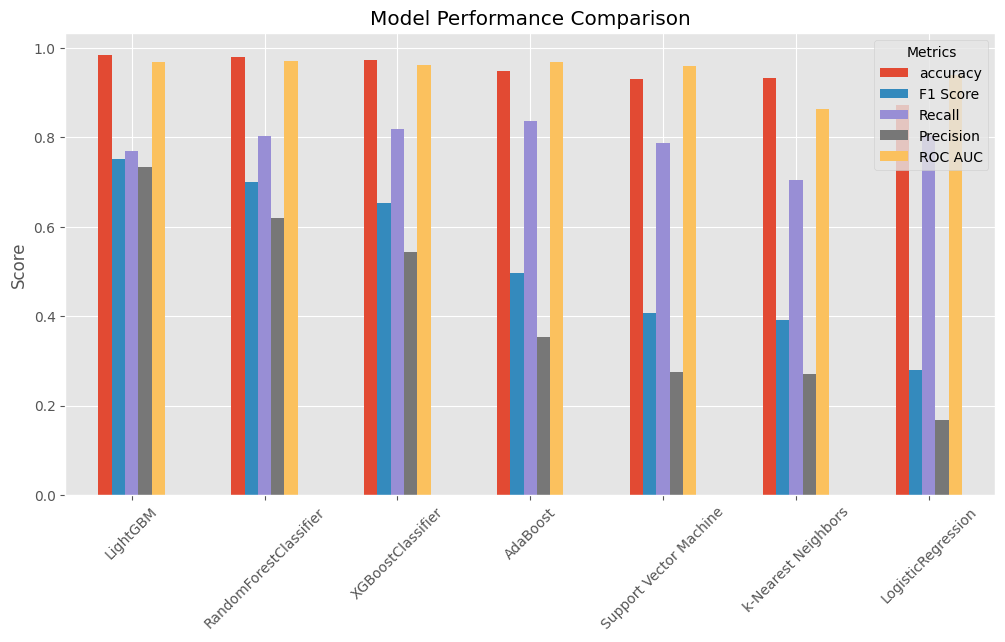

In [46]:
model_results.plot(kind="bar", figsize=(12,6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xticks(rotation=45)
plt.legend(title="Metrics")
plt.show()

In [47]:
#Analyze the Best Model

# Identify the best model based on F1-Score
best_model_name = model_results.index[0]
best_model = trained_models[best_model_name]
best_results = model_results.iloc[0]

In [57]:
print(f"\n Analysis of Best Model: {best_model_name}")
print("=" * 50)
print(f"Best F1-Score: {best_results['F1 Score']:.4f}")
print(f"Best Recall:   {best_results['Recall']:.4f}")


 Analysis of Best Model: LightGBM
Best F1-Score: 0.7520
Best Recall:   0.7705


In [58]:
y_pred_best = best_model.predict(X_test_final)
y_pred_proba_best = best_model.predict_proba(X_test_final)[:, 1]


Confusion Matrix:


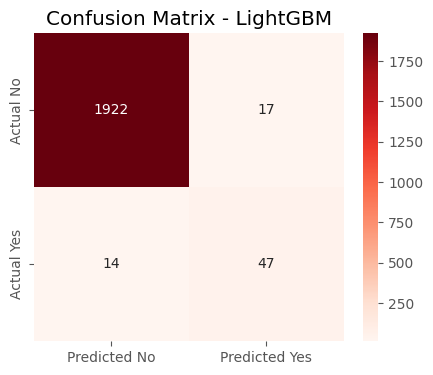

In [63]:
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds',
            xticklabels=['Predicted No', 'Predicted Yes'],
            yticklabels=['Actual No', 'Actual Yes'])
plt.title(f'Confusion Matrix - {best_model_name}')
plt.show()

Feature Importance Analysis (For Tree-Based Models)